# Import libraries

In [1]:
#import libraries
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing, neighbors
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

# Load Data From CSV File

In [2]:
# import data
df=pd.read_csv("https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv")

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

In [3]:
df.head(5)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

In [5]:
dftest=pd.read_csv("https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv")

In [6]:
dftest.shape

(54, 10)

In [7]:
df_new = pd.concat([df, dftest], axis=0)

In [8]:
df_new.shape

(400, 10)

In [9]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 53
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      400 non-null    int64 
 1   Unnamed: 0.1    400 non-null    int64 
 2   loan_status     400 non-null    object
 3   Principal       400 non-null    int64 
 4   terms           400 non-null    int64 
 5   effective_date  400 non-null    object
 6   due_date        400 non-null    object
 7   age             400 non-null    int64 
 8   education       400 non-null    object
 9   Gender          400 non-null    object
dtypes: int64(5), object(5)
memory usage: 34.4+ KB


In [10]:
df_new.tail(5)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
49,348,348,COLLECTION,1000,30,9/11/2016,10/10/2016,32,High School or Below,male
50,349,349,COLLECTION,800,15,9/11/2016,9/25/2016,29,college,male
51,369,369,COLLECTION,1000,30,9/11/2016,10/10/2016,37,High School or Below,male
52,370,370,COLLECTION,800,15,9/11/2016,9/25/2016,36,High School or Below,male
53,396,396,COLLECTION,1000,30,9/12/2016,10/11/2016,33,High School or Below,male


In [11]:
df_new.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

In [12]:
df_new.shape

(400, 8)

In [13]:
# Out of 400 loans, 300 are paidoff and 100 are in collection
df_new["loan_status"].value_counts().to_frame()

,loan_status
PAIDOFF,300
COLLECTION,100


In [14]:
# 337 lenders are male, 63 are female
df_new["Gender"].value_counts().to_frame()

,Gender
male,337
female,63


In [15]:
# Out of 400 loans, only 4 are to clients with Master or Above
df_new["education"].value_counts().to_frame()

,education
High School or Below,172
college,172
Bechalor,52
Master or Above,4


Correcting typo on "Bechalor" and drop "Master of Above" due to only 4 data points

In [16]:
df_new['education'].replace({'Bechalor':"Bachelor"}, inplace=True)

In [17]:
Master = df_new[ df_new['education'] == "Master or Above" ].index
df_new.drop(Master, inplace=True)
df_new["education"].value_counts().to_frame()

,education
High School or Below,172
college,171
Bachelor,50


Transforming dates as objects to datetime values

In [18]:
df_new['effective_date'] = pd.to_datetime(df_new['effective_date'])
df_new['due_date'] = pd.to_datetime(df_new['due_date'])
df_new.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male
5,PAIDOFF,1000,30,2016-09-09,2016-10-08,36,college,male


In [19]:
# no missing values in dataframe
sum(df_new.apply(lambda x: sum(x.isnull().values), axis = 1)>0)

0

In [20]:
%conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


Most principals are for 1000 and 800$, given to 24 -35 year old people for mostly 30 and 15 days terms

In [21]:
df_new.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.838710
        COLLECTION     0.161290
male    PAIDOFF        0.734139
        COLLECTION     0.265861
Name: loan_status, dtype: float64

84% of females pay back their loans on time, while only 73% of male applicants pay off their loan on time

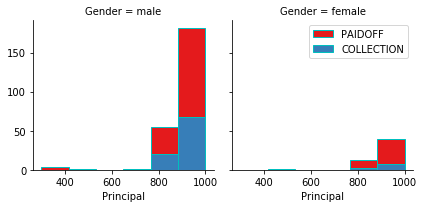

In [22]:
import seaborn as sns
bins = np.linspace(df_new.Principal.min(), df_new.Principal.max(), 7)
g = sns.FacetGrid(df_new, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="c")
g.axes[1].legend()
plt.show()

Most principals and collection are between 800 and 1000, we can therefore focus on principals above 800$

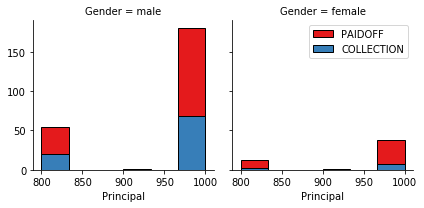

In [23]:
df_new = df_new[df_new.Principal >=800]
bins = np.linspace(800,1000,7)
g = sns.FacetGrid(df_new, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")
g.axes[1].legend()
plt.show()

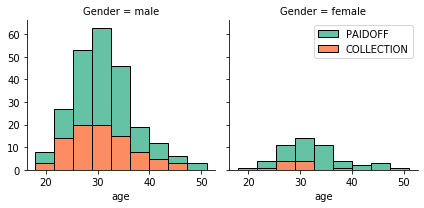

In [24]:
bins = np.linspace(df_new.age.min(), df_new.age.max(), 10)
s = sns.FacetGrid(df_new, col="Gender", hue="loan_status", palette="Set2", col_wrap=2)
s.map(plt.hist, 'age', bins=bins, ec="k")
s.axes[1].legend()
plt.show()

Most loans are given to 20 to 40 year old clients

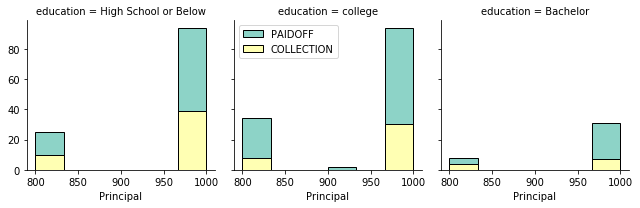

In [25]:
bins = np.linspace(800,1000, 7)
c = sns.FacetGrid(df_new, col="education", hue="loan_status", palette="Set3", col_wrap=3)
c.map(plt.hist, 'Principal', bins=bins, ec="k")
c.axes[1].legend()
plt.show()

Most loans were granted to low education or college students

In [26]:
df_new.to_excel("ML best classifier.xlsx")

In [27]:
df_new['Gender'].replace(to_replace=['female','male'], value=[0,1],inplace=True)
df_new['education'].replace(to_replace=['High School or Below','Bachelor', "college"], value=[1,2,3],inplace=True)
df_new['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,2],inplace=True)

df_new.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1000,30,2016-09-08,2016-10-07,45,1,1
2,1,1000,15,2016-09-08,2016-09-22,27,3,1
3,1,1000,30,2016-09-09,2016-10-08,28,3,0
4,1,1000,30,2016-09-09,2016-10-08,29,3,1
5,1,1000,30,2016-09-09,2016-10-08,36,3,1


#### Paidoff loans are now labeled as "1" in loan_status, those in collection are labeled as "2"

In [28]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386 entries, 0 to 53
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   loan_status     386 non-null    int64         
 1   Principal       386 non-null    int64         
 2   terms           386 non-null    int64         
 3   effective_date  386 non-null    datetime64[ns]
 4   due_date        386 non-null    datetime64[ns]
 5   age             386 non-null    int64         
 6   education       386 non-null    int64         
 7   Gender          386 non-null    int64         
dtypes: datetime64[ns](2), int64(6)
memory usage: 27.1 KB


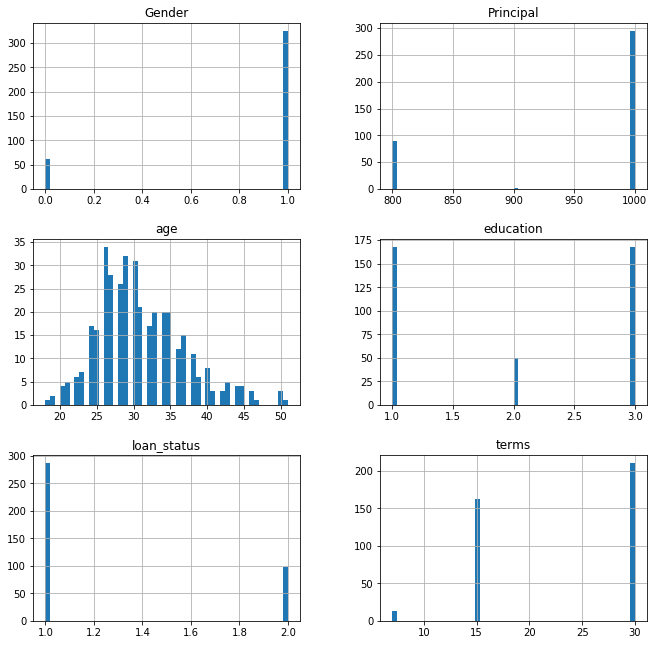

In [29]:
df_new.hist(bins=50,figsize=(11,11))
plt.show()

## Rebalancing:  the dataset is not balanced re loan_status, Gender etc. 
#### But we will not rebalance as paidoff loans are three times more likely than those in collection and a key characteristic of the dataset.

In [30]:
# pro memoria how to downsample which we are not going to do
#from sklearn.utils import resample

#df_maj=df_new[df_new.loan_status==1]
#df_min=df_new[df_new.loan_status==2]

#df_new_maj_dsample=resample(df_maj, replace=False, n_samples=98,random_state=0)

#df_new=pd.concat([df_new_maj_dsample,df_min])

#df_new.loan_status.value_counts()

In [31]:
df_ML=df_new[["Gender","age","education","Principal","terms"]]

In [32]:
X = df_ML

In [33]:
y = df_new['loan_status'].values

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_testKNN = train_test_split(X, y, test_size=0.35, random_state=0,stratify=y)

### Normalisation of data with MinMaxScaler

In [35]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
# we need to apply the scaling to the test set that we computed for the training set
X_test_scaled = scaler.transform(X_test)

In [36]:
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_testKNN.shape)

Train set: (250, 5) (250,)
Test set: (136, 5) (136,)


# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Aim is the best k to build the model with the best accuracy.  

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [38]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhatKNN=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_testKNN, yhatKNN)

    
    std_acc[n-1]=np.std(yhatKNN==y_testKNN)/np.sqrt(yhatKNN.shape[0])

mean_acc

array([0.52941176, 0.69117647, 0.66911765, 0.73529412, 0.72058824,
       0.72794118, 0.70588235, 0.72058824, 0.70588235])

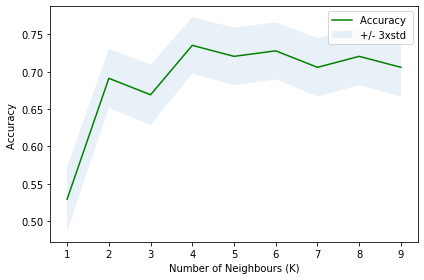

In [39]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

In [40]:
knn = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = knn).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [41]:
# yhat is the predicted value that gets compared to the actual value of the test set.
yhatKNN = neigh.predict(X_test)
yhatKNN[0:5]

array([1, 1, 1, 1, 1])

In [42]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_testKNN, yhatKNN))

Train set Accuracy:  0.768
Test set Accuracy:  0.7352941176470589


In [43]:
print( "The best accuracy was with", mean_acc.max(), "with knn=", mean_acc.argmax()+1) 

The best accuracy was with 0.7352941176470589 with knn= 4


### KNN Metrics

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [45]:
from collections import Counter
Counter(y_train)
Counter(y_testKNN)

Counter({1: 101, 2: 35})

In [46]:
clf=neighbors.KNeighborsClassifier()

In [47]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [48]:
accuracy=clf.score(X_test,yhatKNN)

In [49]:
print(accuracy)

0.9558823529411765


In [50]:
knn_f1 = f1_score(y_testKNN, yhatKNN)
knn_f1

0.8448275862068965

In [51]:
#K nearest neighbors
knn_pred = clf.predict(X_test)
knn_jaccard = jaccard_score(y_testKNN, yhatKNN)
knn_jaccard

0.7313432835820896

In [52]:
print(classification_report(y_testKNN, yhatKNN))

              precision    recall  f1-score   support

           1       0.75      0.97      0.84       101
           2       0.40      0.06      0.10        35

    accuracy                           0.74       136
   macro avg       0.57      0.51      0.47       136
weighted avg       0.66      0.74      0.65       136



#### Practical example: Getting a prediction/classification on the loan model with 2 male applicants. The one with college vs. the other man with lower education

In [53]:
example_loan = np.array([1,26,3,1000,30])

In [54]:
example_loan=example_loan.reshape(1,-1)

In [55]:
prediction=clf.predict(example_loan)

In [56]:
print(prediction)

[1]


#### Applicants with college education "3" in array, are predicted to repay their loans

In [57]:
example_loan2 = np.array([1,26,1,1000,30])

In [58]:
example_loan2=example_loan2.reshape(1,-1)

In [59]:
prediction=clf.predict(example_loan2)

In [60]:
print(prediction)

[2]


#### Applicants with low education "1" in array, are predicted with KNN and k=4 to go into collection of their loans

## DECISION TREE CLASSIFIER (DTC)

In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [62]:
X_trainDTC, X_testDTC, y_trainDTC, y_testDTC = train_test_split(X, y, test_size=0.35, random_state=0, stratify=y)
#Modelling
Tree = DecisionTreeClassifier(criterion="entropy")
Tree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [63]:
scaler = MinMaxScaler()
X_trainDTC_scaled = scaler.fit_transform(X_trainDTC)
# we need to apply the scaling to the test set that we computed for the training set
X_testDTC_scaled = scaler.transform(X_testDTC)

In [64]:
from collections import Counter
Counter(y_trainDTC)
Counter(y_testDTC)

Counter({1: 101, 2: 35})

In [65]:
print ('Trainset:', X_trainDTC.shape,  y_trainDTC.shape)
print ('Testset:', X_testDTC.shape,  y_testDTC.shape)

Trainset: (250, 5) (250,)
Testset: (136, 5) (136,)


In [66]:
Tree.fit(X_trainDTC,y_trainDTC)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [67]:
y_hatDTC= Tree.predict(X_testDTC)
print (y_hatDTC [0:5])
print (y_testDTC [0:5])

print("Accuracy: ", metrics.accuracy_score(y_testDTC, y_hatDTC))

[1 1 1 2 1]
[1 2 2 2 1]
Accuracy:  0.6838235294117647


In [68]:
Tree_f1 = f1_score(y_testDTC, y_hatDTC)
Tree_f1

0.7981220657276994

In [69]:
#decision tree
tree_jaccard = jaccard_score(y_testDTC, y_hatDTC)
print (tree_jaccard)

0.6640625


In [70]:
print(classification_report(y_testDTC, y_hatDTC))

              precision    recall  f1-score   support

           1       0.76      0.84      0.80       101
           2       0.33      0.23      0.27        35

    accuracy                           0.68       136
   macro avg       0.55      0.54      0.53       136
weighted avg       0.65      0.68      0.66       136



#### Practical example analog example_loan2 with kNN: Decision Tree algorithm comes to a "2" (collection) prediction like KNN with k=4 

In [71]:
example_loan3 = np.array([1,26,1,1000,30])

In [72]:
example_loan3=example_loan3.reshape(1,-1)

In [73]:
prediction=Tree.predict(example_loan3)

In [74]:
print(prediction)

[2]


## SUPPORT VECTOR MODEL

In [75]:
from sklearn import svm

In [76]:
X_trainSVM, X_testSVM, y_trainSVM, y_testSVM = train_test_split(X, y, test_size=0.35, random_state=0, stratify=y)
svm_classifier = svm.SVC(C=0.01, kernel='linear')
svm_classifier

SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [77]:
from collections import Counter
Counter(y_trainSVM)
Counter(y_testSVM)

Counter({1: 101, 2: 35})

In [78]:
scaler = MinMaxScaler()
X_trainSVM_scaled = scaler.fit_transform(X_trainSVM)
# we need to apply the scaling to the test set that we computed for the training set
X_testSVM_scaled = scaler.transform(X_testSVM)

In [79]:
print ('Trainset:', X_trainSVM.shape,  y_trainSVM.shape)
print ('Testset:', X_testSVM.shape,  y_testSVM.shape)

Trainset: (250, 5) (250,)
Testset: (136, 5) (136,)


In [80]:
svm_classifier.fit(X_trainSVM,y_trainSVM)
y_hatSVM=svm_classifier.predict(X_testSVM)

In [81]:
print (y_hatSVM [0:5])
print (y_testSVM [0:5])

print("Accuracy: ", metrics.accuracy_score(y_testSVM, y_hatSVM))

[1 1 1 1 1]
[1 2 2 2 1]
Accuracy:  0.7426470588235294


In [82]:
#SVM
svm_jaccard = jaccard_score(y_testSVM, y_hatSVM)
print (svm_jaccard)

0.7426470588235294


In [83]:
SVM_f1 = f1_score(y_testSVM,y_hatSVM)
SVM_f1

0.8523206751054853

In [84]:
print(classification_report(y_testSVM, y_hatSVM))

              precision    recall  f1-score   support

           1       0.74      1.00      0.85       101
           2       0.00      0.00      0.00        35

    accuracy                           0.74       136
   macro avg       0.37      0.50      0.43       136
weighted avg       0.55      0.74      0.63       136



/Users/Martin/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Practical example analog example_loan2 with kNN: SVM comes to a "1" prediction contrary to KNN and Decision Tree

In [85]:
example_loan4 = np.array([1,26,1,1000,30])

In [86]:
example_loan4=example_loan4.reshape(1,-1)

In [87]:
prediction=svm_classifier.predict(example_loan4)

In [88]:
print(prediction)

[1]


## Logistic regression

In [89]:
from sklearn.linear_model import LogisticRegression

In [90]:
from sklearn.model_selection import train_test_split
X_trainLR, X_testLR, y_trainLR, y_testLR = train_test_split( X, y, test_size=0.35, random_state=0, stratify=y)
print ('Train LR:', X_trainLR.shape,  y_trainLR.shape)
print ('Test LR:', X_testLR.shape,  y_testLR.shape)

Train LR: (250, 5) (250,)
Test LR: (136, 5) (136,)


In [91]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_trainLR,y_trainLR)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [92]:
from collections import Counter
Counter(y_trainLR)
Counter(y_testLR)

Counter({1: 101, 2: 35})

In [93]:
scaler = MinMaxScaler()
X_trainLR_scaled = scaler.fit_transform(X_trainLR)
# we need to apply the scaling to the test set that we computed for the training set
X_testLR_scaled = scaler.transform(X_testLR)

In [94]:
y_hatLR = LR.predict(X_testLR)
print (y_hatLR [0:5])
print (y_testLR [0:5])

print("Accuracy: ", metrics.accuracy_score(y_testLR, y_hatLR))

[1 1 1 1 1]
[1 2 2 2 1]
Accuracy:  0.7426470588235294


In [95]:
LR_f1 = f1_score(y_testLR,y_hatLR)
LR_f1

0.8523206751054853

In [96]:
print(classification_report(y_testLR, y_hatLR))

              precision    recall  f1-score   support

           1       0.74      1.00      0.85       101
           2       0.00      0.00      0.00        35

    accuracy                           0.74       136
   macro avg       0.37      0.50      0.43       136
weighted avg       0.55      0.74      0.63       136



/Users/Martin/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Logloss metrics for Logistic Regression solely

In [97]:
from sklearn.metrics import log_loss
log_loss(y_testLR, y_hatLR)

25.650714523723735

#### Practical example analog example_loan2 with kNN:  Logistic Regression comes to a "1" prediction like SVM.

In [98]:
example_loan5 = np.array([1,26,1,1000,30])

In [99]:
example_loan5=example_loan5.reshape(1,-1)

In [100]:
prediction=LR.predict(example_loan5)

In [101]:
print(prediction)

[1]


### SUMMARY

In [102]:
#test the KNN algorithm already trained with K=4
KNNJaccard = jaccard_score(y_testKNN, yhatKNN)
KNNF1 = f1_score(y_testKNN, yhatKNN)
print("KNN F1-score: %.2f" % KNNF1 )
print("KNN Jaccard Score: %.2f" % KNNJaccard)

KNN F1-score: 0.84
KNN Jaccard Score: 0.73


In [103]:
DTCJaccard = jaccard_score(y_testDTC, y_hatDTC)
DTCF1 = f1_score(y_testDTC, y_hatDTC)
print("Decision Tree F1-score: %.2f" % DTCF1 )
print("Decision Tree Jaccard Score: %.2f" % DTCJaccard)

Decision Tree F1-score: 0.80
Decision Tree Jaccard Score: 0.66


In [104]:
SVMJaccard = jaccard_score(y_testSVM, y_hatSVM)
SVMF1 = f1_score(y_testSVM, y_hatSVM)
print("SVM F1-score: %.2f" % SVMF1)
print("SVM Jaccard score: %.2f" % SVMJaccard)

SVM F1-score: 0.85
SVM Jaccard score: 0.74


In [105]:
LogRJaccard = jaccard_score(y_testLR, y_hatLR)
LogRF1 = f1_score(y_testLR, y_hatLR)
Logloss = log_loss(y_testLR, y_hatLR)
print("LogLoss: : %.2f" % Logloss)
print("LR F1-score: %.4f" % LogRF1)
print("LR Jaccard score: %.4f" % LogRJaccard)

LogLoss: : 25.65
LR F1-score: 0.8523
LR Jaccard score: 0.7426


### The best classifier is KNN with k=4. Decision Tree reaches slightly lower scores of F1 and Jaccard. Both SVM and Logistic Regression suffer from 0 values for precision of "2" predictions. Overall the dataset was small, leading to the differences in classifications between the four ML algorithms: KNN and DTC forecasted on a specific example a "2" ("paidoff"), while SVM and LR predicted a "1" ("in collection")